In [ ]:
!pip install yahoo_fin

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import datetime as dt
from datetime import timedelta

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
from yahoo_fin.stock_info import get_data

#**Let's create a LSTM module** 

We will train it first on a set of sinus and cosinusoides series and see if the LSTM module can learn the right patterns. To add difficulty, we will not use simple one period series but a sum of sines and cosines with different period to make a set of more difficult patterns to learn. 

We will then use our LSTM module on a set of financial timeseries returns to test its validity on stochastic timeseseries.

In [ ]:
# generating a sample of sinusoides function: a fourier series in short

x = np.linspace(0, 150, 150) 
x_sample = []
for i in range(310):
  y1 = np.sum([np.sin(random.randint(1, 8)*np.pi*x) for i in range(1, random.randint(1, 4)+1)], axis=0) # components sin : between 1 and 4 
  y2 = np.sum([np.sin(random.randint(1, 10)*np.pi*x)**2 for i in range(1, random.randint(0, 2)+1)], axis=0) # components sqrt sin : between 0 and 2
  y3 = np.sum([np.cos(random.randint(1, 2)*np.pi*x) for i in range(1, random.randint(1, 3)+1)], axis=0) # components cos : between 1 an 3
  y4 = np.sum([np.cos(random.randint(1, 3)*np.pi*x)**2 for i in range(1, random.randint(0, 2)+1)], axis=0) # component sqrt cos : between 0 and 2
  x_sample.append(y2+y1+y3+y4)


x_sample = torch.from_numpy(np.stack(x_sample, axis = 0))
print(x_sample.shape)


torch.Size([310, 150])


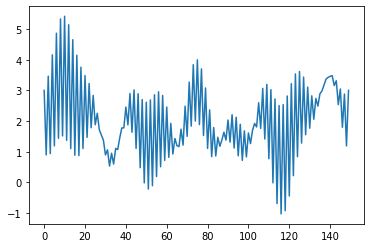

In [ ]:
plt.plot(x_sample[3,:])
plt.show()

In [ ]:

a = 0.1
y = x_sample[:, int(x_sample.shape[1]*(1-a)):]
X_train, X_test, y_train, y_test = train_test_split(x_sample[:, :int(x_sample.shape[1]*(1-a))], y, test_size = 0.2, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(type(y_train))



torch.Size([248, 135])
torch.Size([248, 15])
<class 'torch.Tensor'>


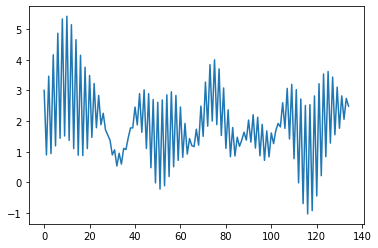

In [ ]:
plt.plot(X_train[3, :])
plt.show()

We implement what we call an "autoregressive" LSTM meaning we have a univariate timeseries and the features passed to the network are the previous timesteps.

In [ ]:
# reshaping to the format Pytorch expect: so a 3D tensor where our "rows" will be depth
X_train_final = torch.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_final = torch.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train_final = torch.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
y_test_final = torch.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

print("Training shape", X_train_final.shape, y_train_final.shape)
print("Test shape", X_test_final.shape, y_test_final.shape)

Training shape torch.Size([248, 1, 135]) torch.Size([248, 1, 15])
Test shape torch.Size([62, 1, 135]) torch.Size([62, 1, 15])


In [ ]:
# let's create our LSTM module net: with 2 lstm layers and a ReLU as activation function


class test_LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers=1):
    super(test_LSTM, self).__init__()
    self.input_size = input_size # nb of features of x: so here m: train sequence lenght
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.midsize = int(round(self.input_size/2, 0))
    # model initialization : initialization of the main layers is to be done in the class, 
    self.lstm = nn.LSTM(input_size = self.input_size, hidden_size = self.midsize , num_layers = self.num_layers) # initialization
    self.lstm2 = nn.LSTM(input_size = self.midsize, hidden_size = self.hidden_size, num_layers = self.num_layers)
    
    self.fc1 = nn.Linear(self.hidden_size, 128) # what passes through the second layer is the hidden state, there is no other output
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(128, self.hidden_size) # hidden_size is the same as output size here but we could make it different 
    
    # we could make an even more complex one by adding another lstm cell at the output: or make a third one to chunk even more the hidden state


    # forward pass
  def forward(self, x):
    size_sample= x.shape[0]
    outputs = [] # let's try a first emppty list with the passing each time step one by one method
    # define the initial hidden states:
    h_0 = torch.zeros(self.num_layers, 1, self.midsize , dtype=torch.float32)
    c_0 = torch.zeros(self.num_layers, 1, self.midsize , dtype=torch.float32)
    h_2 = torch.zeros(self.num_layers, 1, self.hidden_size, dtype=torch.float32)
    c_2 = torch.zeros(self.num_layers, 1, self.hidden_size, dtype=torch.float32)
    num_timestep = x.shape[0]

    for t in range(num_timestep):
      # reshape input
      input_t = x[t].view(1, 1, self.input_size)
      output_lstm1, (h_n, c_n) = self.lstm(input_t, (h_0, c_0))
      output_lstm2, (h_n2, c_n2) = self.lstm2(h_n, (h_2, c_2)) # new hidden and cell states
      #h_n2 = h_n2.view(-1, self.hidden_size) # reshape h_n for FC layer
    
      out = self.fc1(h_n2)
      out = self.relu(out)
      out = self.fc2(out)
      outputs.append(out)
    outputs = torch.cat(outputs, dim=0)
    return outputs
  



In [ ]:
# model initialization 
n_epochs = 1000
lr = 0.008
input_size = 135 # nb of features in the x data: it means the lenght of the timeseries we want to assess here we have an example with 5
hidden_size = 15 # nb of features in hidden state
nb_layers = 1 # nb of stacked lstm layers : 1

# initialization of loss and optimizer: 

my_lstm = test_LSTM(input_size, hidden_size, nb_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(my_lstm.parameters(), lr = lr)
for param in my_lstm.parameters():
    param.requires_grad = True

In [ ]:
# training loop:
loss_series = []
for epoch in range(n_epochs):
  optimizer.zero_grad()
  out = my_lstm.forward(X_train_final.float()) # pass input to forward pass
  loss = criterion(out, y_train_final.float())
  loss_series.append(loss.item())

  loss.backward()
  if epoch % 100 == 0:
    print("Epoch: {}, loss {}".format(epoch, loss.item()))
  # update weights with optimizer.step
  
  optimizer.step()





Epoch: 0, loss 5.565633296966553
Epoch: 100, loss 0.03619919344782829
Epoch: 200, loss 0.005648278631269932
Epoch: 300, loss 0.0018003794830292463
Epoch: 400, loss 0.000982773257419467
Epoch: 500, loss 0.0008243130287155509
Epoch: 600, loss 0.0005680879112333059
Epoch: 700, loss 0.0007601379184052348
Epoch: 800, loss 0.0005522774299606681
Epoch: 900, loss 0.00038637506077066064


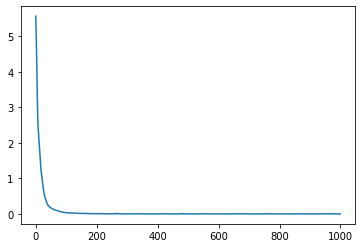

In [ ]:
# make a plot for the loss: here with the relu

plt.plot(loss_series)
plt.show()

In [ ]:
# prediction: 
pred = my_lstm(X_test_final.float()).detach()
testloss = criterion(pred, y_test_final.float())
print(testloss)

tensor(0.6207)


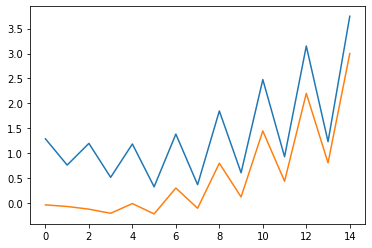

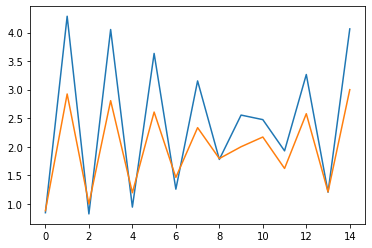

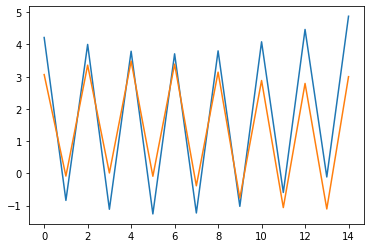

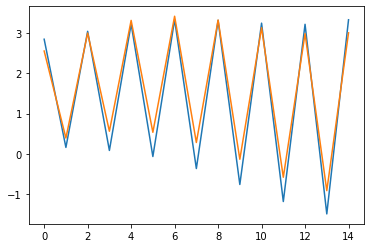

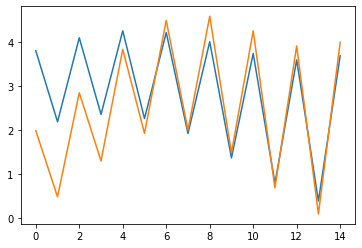

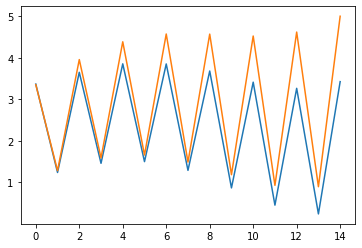

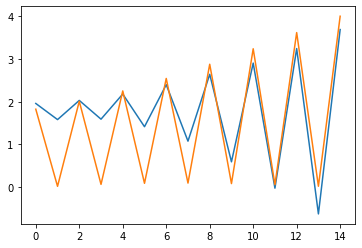

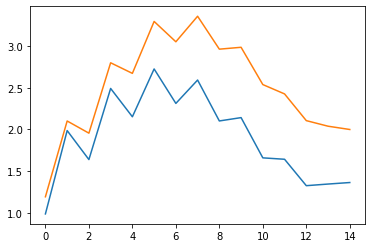

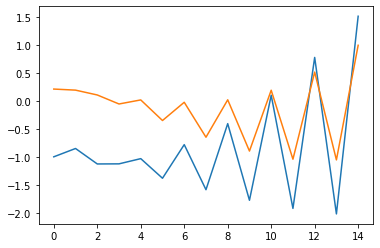

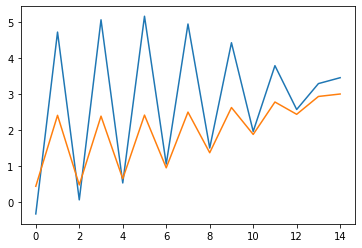

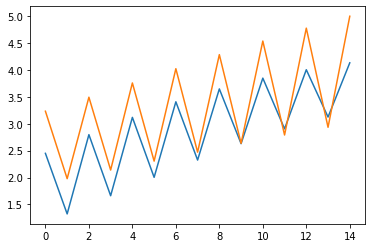

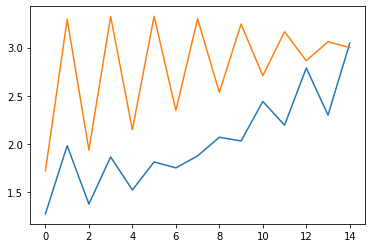

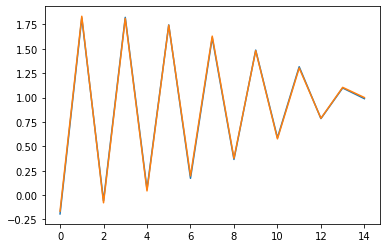

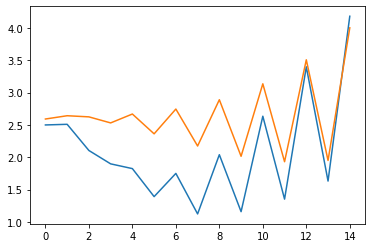

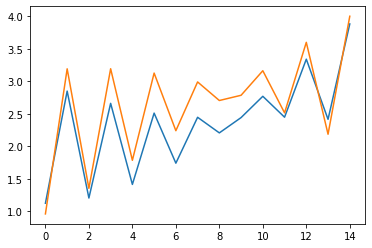

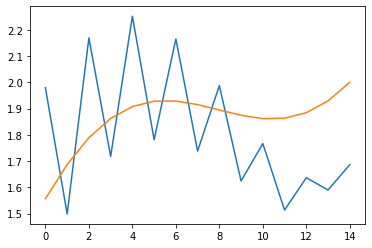

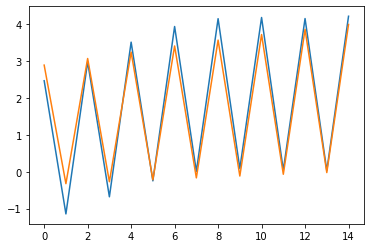

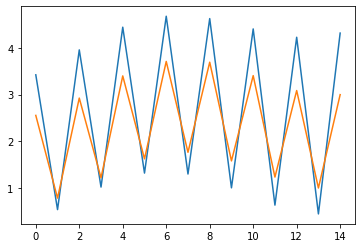

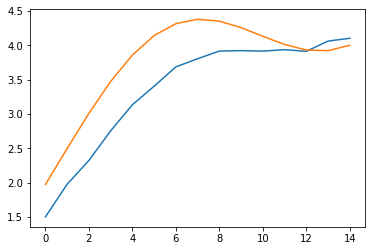

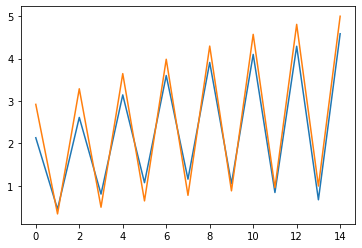

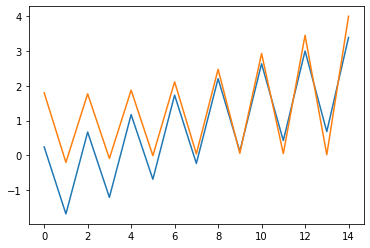

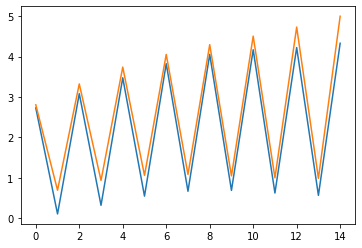

In [ ]:
# must reduce the dimension to plot prediction


for i in range(22):
  a = pred[i][0]
  b = y_test_final[i][0]
  plt.plot(a, label = "pred")
  plt.plot(b, label="true series")
  plt.show()


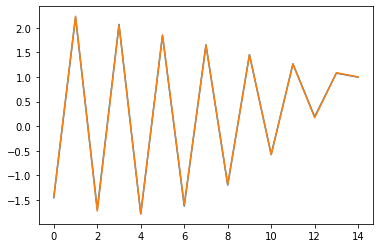

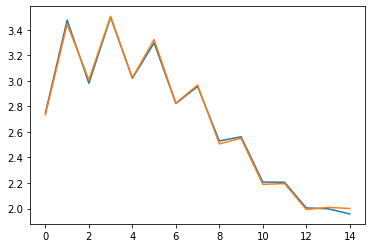

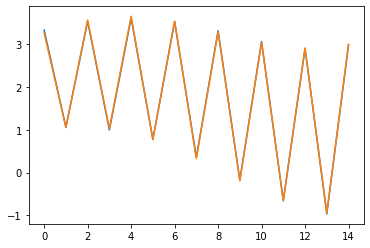

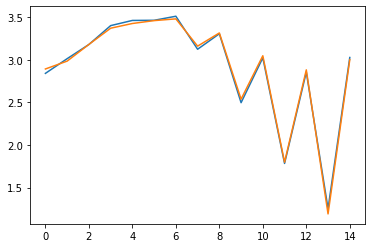

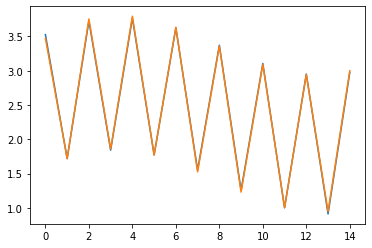

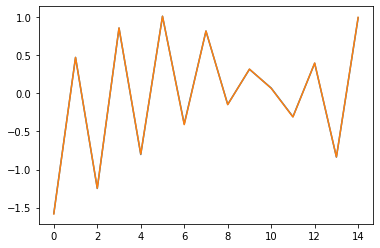

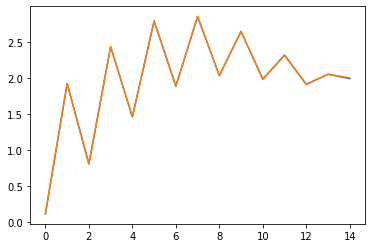

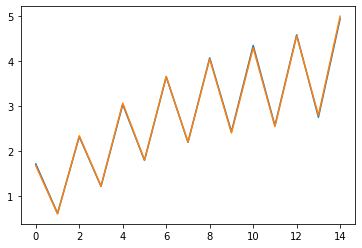

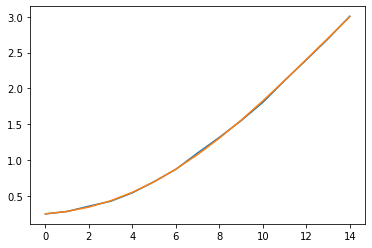

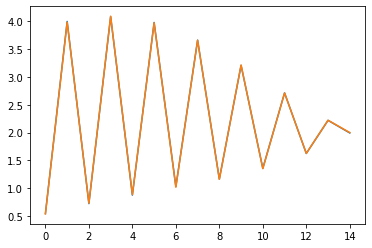

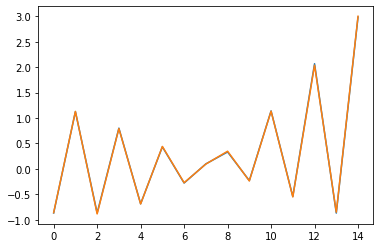

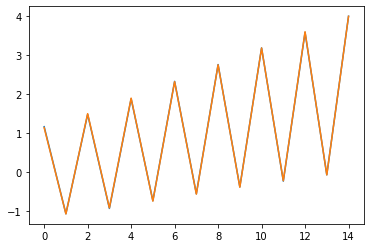

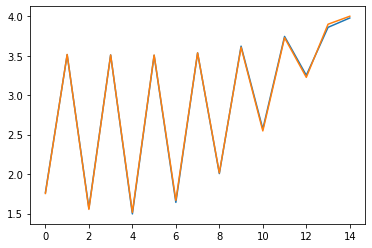

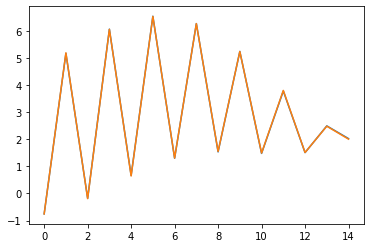

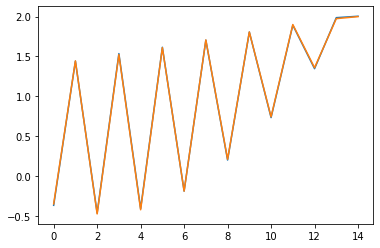

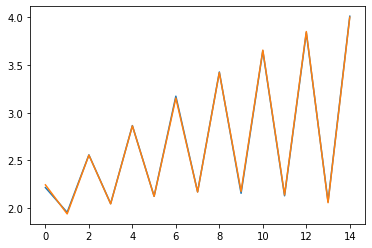

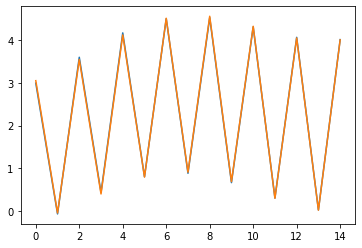

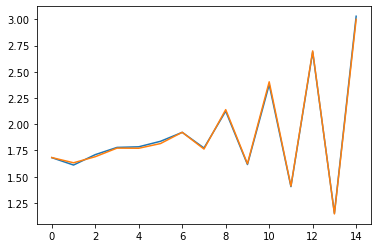

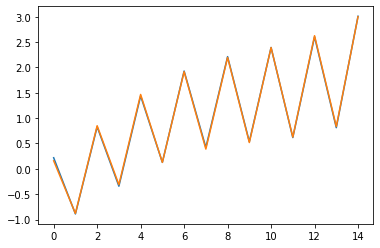

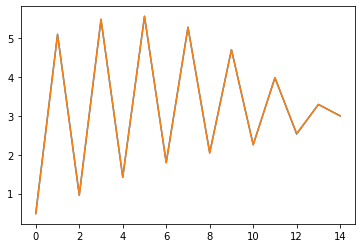

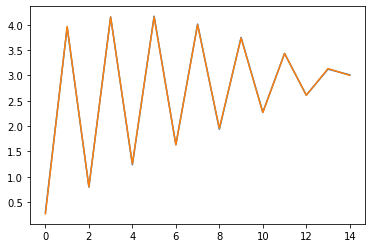

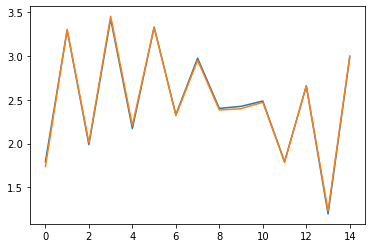

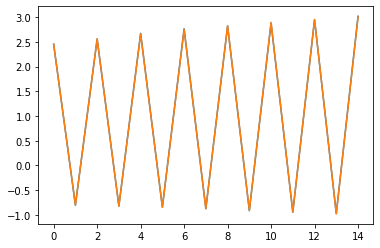

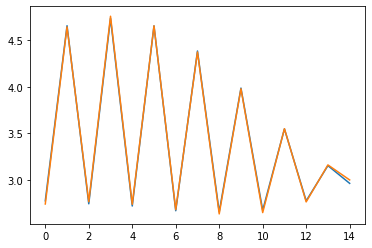

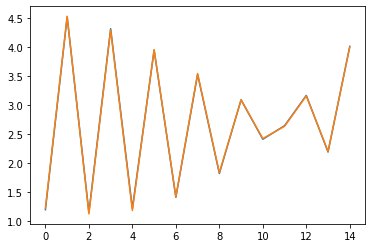

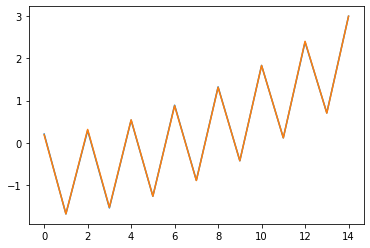

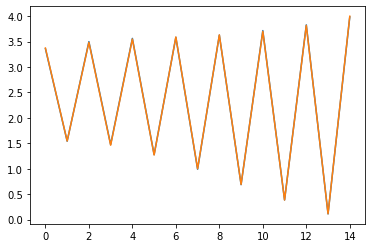

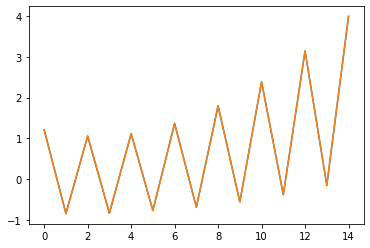

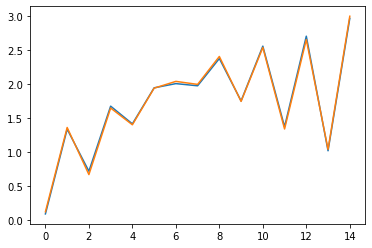

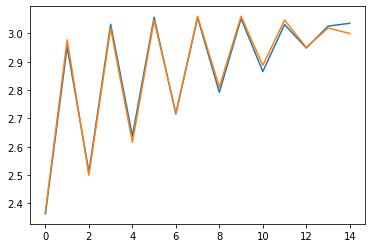

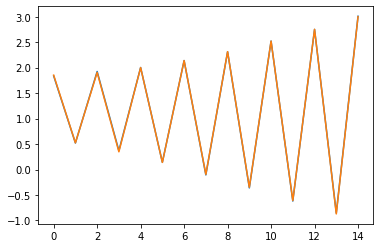

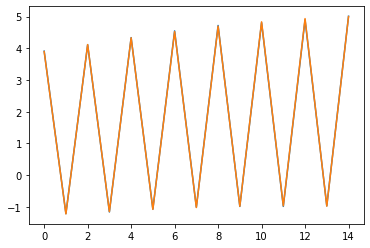

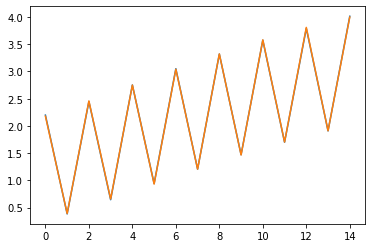

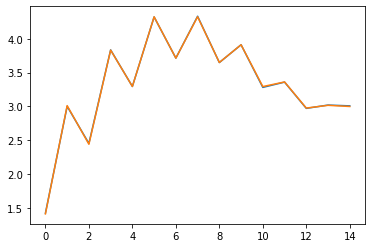

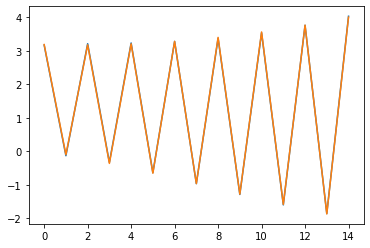

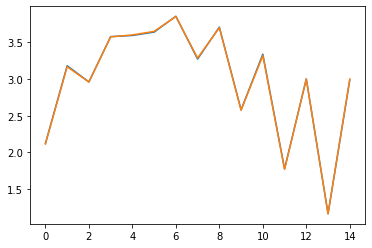

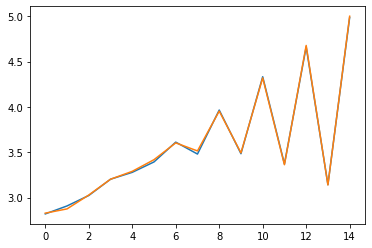

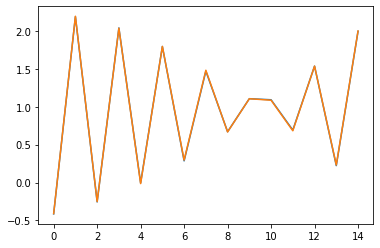

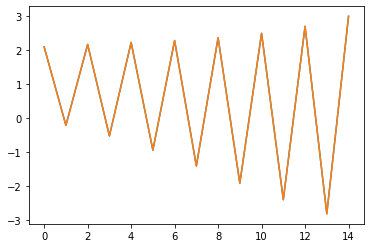

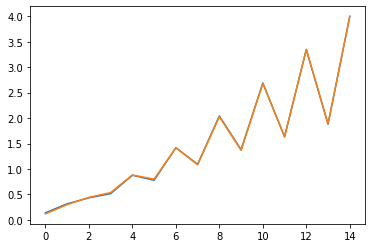

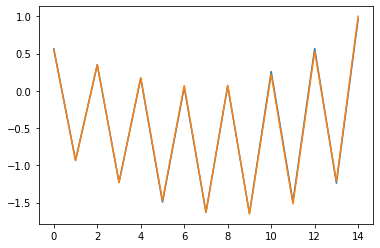

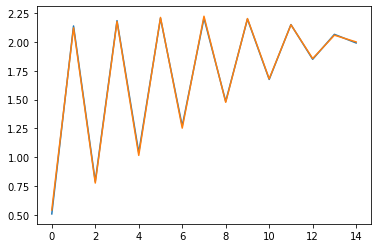

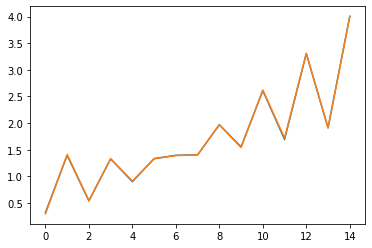

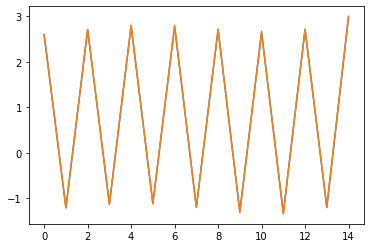

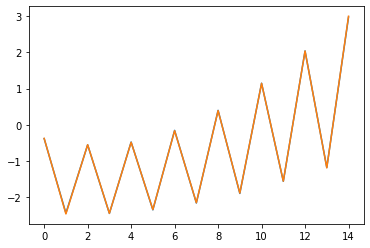

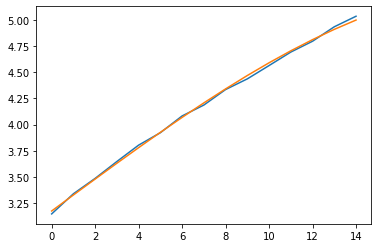

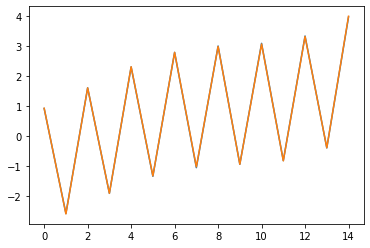

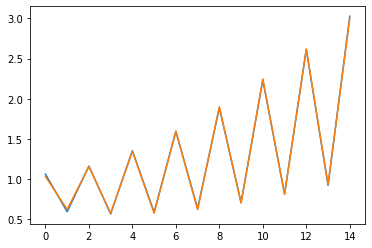

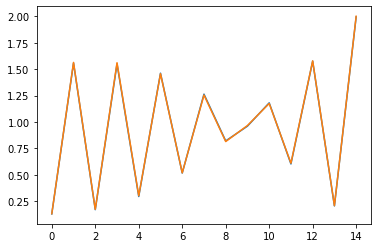

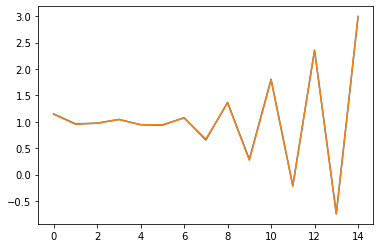

In [ ]:
# plot results on training set

for i in range(50):
  a = out[i][0].detach()
  b = y_train_final[i][0]
  plt.plot(a, label = "pred")
  plt.plot(b, label="true series")
  plt.show()



In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# we load a set of financial stock price to populate our dataset: the choices are completely arbitrary

ticker_list = ['MSFT', 'AKAM', 'SSNC', 'VIAC', 'EXPE', 'ROKU',
               'AAPL', 'AMZN',
               'GOOG', 'GRMN', 'VOD', 
               'INTC', 'CMCSA', 'PEP', 
               'ADBE', 'CSCO', 'NVDA', 
               'NFLX', 'TSLA', 'COST', 'PYPL', 'AMGN', 
               'SNY', 'ASML', 'AVGO', 'TXN', 
               'CHTR', 'SBUX', 'GILD', 'QCOM', 'TMUS', 
               'MDLZ', 'FISV', 'CME', 'INTU', 'BKNG', 
               'ADP', 'ISRG', 'VRTX', 'MU', 'AMD', 
               'BIIB', 'CSX', 'AMAT', 'EQIX', 'JD', 'REGN', 
               'ATVI', 'EXC', 'LRCX', 'NTES', 'WBA', 'ADSK', 'ILMN', 
               'ADI', 'ROST', 'WDAY', 'MAR', 'TEAM', 'MNST', 'XEL', 'CTSH', 'SBAC', 
               'NXPI', 'BIDU', 'MELI', 'EA', 'KHC', 'ZM', 'EBAY', 'TROW', 'LULU', 'CTAS', 
               'PAYX', 'SIRI', 'ORLY', 'VRSK', 'CSGP', 'RYAAY', 'DXCM', 'KLAC', 'ERIC', 'LBRDK', 
               'SPLK', 'PCAR', 'LBRDA', 'PDD', 'VRSN', 'SWKS', 'IDXX', 'MCHP', 'ANSS', 'SNPS',
               'XP', 'WDC', 'AMTD', 'NTRS', 'FAST', 'CPRT', 'SGEN', 'CDNS', 'MTCH', 'NDAQ', 'FOXA']

In [ ]:
df = []
names = []
for i in ticker_list:
  try:
    df.append(get_data(ticker=i, start_date=(dt.datetime.now()-timedelta(days = 250)).strftime('%d/%m/%Y'), end_date=None, index_as_date=None)['close'])
    names.append(i)
  except AssertionError:
    print('no response for df {}'.format(i))

df = pd.concat(df, axis=1)
df.columns = names

no response for df VIAC


/usr/local/lib/python3.7/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()


In [ ]:
df

,MSFT,AKAM,SSNC,EXPE,ROKU,AAPL,AMZN,GOOG,GRMN,VOD,...,WDC,AMTD,NTRS,FAST,CPRT,SGEN,CDNS,MTCH,NDAQ,FOXA
0,299.500000,104.860001,76.269997,213.800003,161.449997,172.550003,158.100494,137.487503,119.589996,18.870001,...,56.389999,3.83,126.279999,52.340000,126.870003,128.669998,145.850006,117.330002,58.220001,43.009998
1,290.730011,102.930000,74.690002,209.309998,144.710007,168.880005,154.652496,132.308502,113.320000,18.690001,...,56.450001,3.80,118.449997,51.279999,124.800003,124.160004,138.220001,111.879997,57.293331,42.910000
2,287.929993,100.330002,73.919998,209.169998,112.459999,167.300003,152.601501,130.467499,114.519997,18.629999,...,55.529999,3.80,118.519997,51.200001,122.320000,120.260002,134.949997,107.559998,57.180000,42.380001
3,287.720001,100.440002,74.209999,204.679993,121.970001,164.320007,150.197495,129.402496,111.830002,18.540001,...,53.419998,3.85,117.410004,51.049999,121.750000,123.440002,135.210007,107.160004,56.323334,41.820000
4,280.269989,98.879997,73.410004,198.630005,118.349998,160.070007,144.826996,127.584999,109.790001,18.320000,...,51.980000,6.87,113.639999,49.619999,117.790001,119.610001,140.880005,104.540001,56.063332,40.970001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,237.529999,82.540001,49.009998,95.279999,52.560001,142.410004,113.790001,100.779999,81.779999,11.520000,...,33.889999,1.08,86.919998,46.099998,110.919998,135.990005,154.070007,44.320000,56.750000,28.580000
168,238.500000,84.379997,49.369999,98.110001,53.230000,143.750000,116.360001,101.389999,82.919998,11.460000,...,33.610001,1.10,87.610001,47.480000,112.540001,134.839996,155.559998,45.980000,57.209999,29.200001
169,236.479996,82.940002,48.410000,96.120003,51.099998,143.860001,115.070000,100.290001,81.199997,11.490000,...,33.360001,1.04,79.589996,46.080002,110.949997,129.830002,153.720001,44.730000,56.000000,29.320000
170,236.149994,84.160004,47.310001,93.150002,51.880001,143.389999,115.250000,100.529999,80.860001,11.220000,...,33.470001,1.03,77.209999,45.349998,108.809998,126.699997,153.050003,42.700001,56.840000,29.010000


In [ ]:
#transform dataset for pytorch

alpha = 0.1
l = len(df)

scaler = MinMaxScaler()
sample = scaler.fit_transform((np.array(df).T))
X = torch.from_numpy(sample[:, :int(l*(1-alpha))])
y = torch.from_numpy(sample[:, int(l*(1-alpha)):])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(type(y_train))

# reshaping to the format Pytorch expect: so a 3D tensor where our "rows" will be depth
X_train_final = torch.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_final = torch.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train_final = torch.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
y_test_final = torch.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

print("Training shape", X_train_final.shape, y_train_final.shape)
print("Test shape", X_test_final.shape, y_test_final.shape)


torch.Size([82, 154])
torch.Size([82, 18])
<class 'torch.Tensor'>
Training shape torch.Size([82, 1, 154]) torch.Size([82, 1, 18])
Test shape torch.Size([21, 1, 154]) torch.Size([21, 1, 18])


In [ ]:
# initialize a model for this new training

n_epochs = 2000
lr = 0.003
input_size = 154 # nb of features in the x data: it means the lenght of the timeseries we want to assess here we have an example with 5
hidden_size = 18 # nb of features in hidden state
nb_layers = 1 # nb of stacked lstm layers : 1

# initialization of loss and optimizer: 

my_lstm = test_LSTM(input_size, hidden_size, nb_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(my_lstm.parameters(), lr = lr)
for param in my_lstm.parameters():
    param.requires_grad = True


In [ ]:
# training loop
loss_series = []
for epoch in range(n_epochs):
  optimizer.zero_grad()
  out = my_lstm.forward(X_train_final.float()) # pass input to forward pass
  loss = criterion(out, y_train_final.float())
  loss_series.append(loss.item())

  loss.backward()
  if epoch % 100 == 0:
    print("Epoch: {}, loss {}".format(epoch, loss.item()))
  # update weights with optimizer.step
  
  optimizer.step()


Epoch: 0, loss 0.03975435346364975
Epoch: 100, loss 0.00013931009743828326
Epoch: 200, loss 0.0001304550823988393
Epoch: 300, loss 6.895175465615466e-05
Epoch: 400, loss 6.146913074189797e-05
Epoch: 500, loss 6.320848478935659e-05
Epoch: 600, loss 6.537709123222157e-05
Epoch: 700, loss 4.944575630361214e-05
Epoch: 800, loss 4.7476558393100277e-05
Epoch: 900, loss 4.395882933749817e-05
Epoch: 1000, loss 4.215900116832927e-05
Epoch: 1100, loss 4.076939876540564e-05
Epoch: 1200, loss 3.7371533835539594e-05
Epoch: 1300, loss 6.095817661844194e-05
Epoch: 1400, loss 3.3793705370044336e-05
Epoch: 1500, loss 3.382873910595663e-05
Epoch: 1600, loss 3.4193406463600695e-05
Epoch: 1700, loss 6.139722972875461e-05
Epoch: 1800, loss 5.0362501497147605e-05
Epoch: 1900, loss 3.1483941711485386e-05


In [ ]:
out.shape

torch.Size([82, 1, 18])

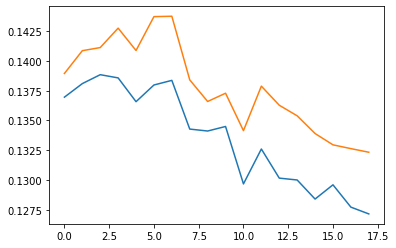

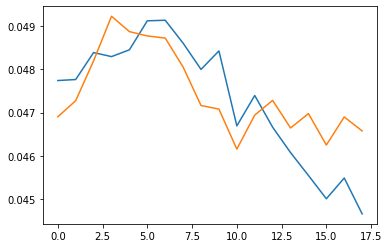

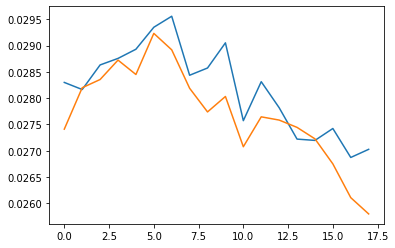

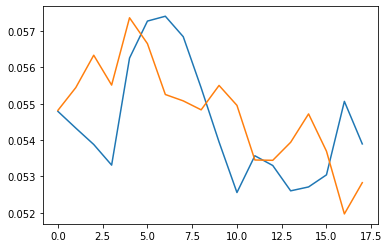

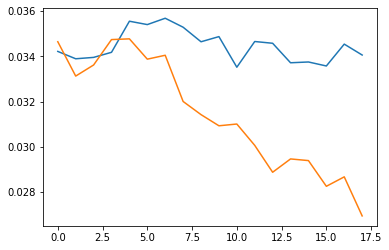

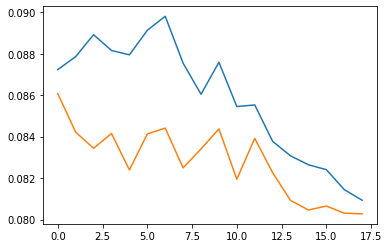

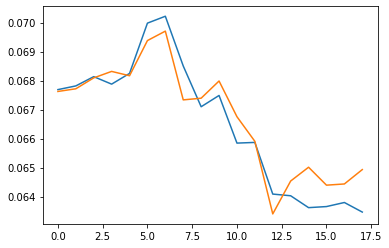

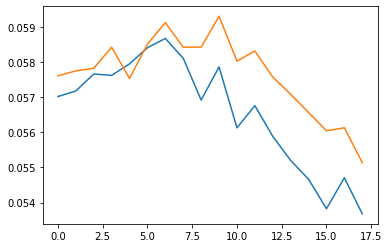

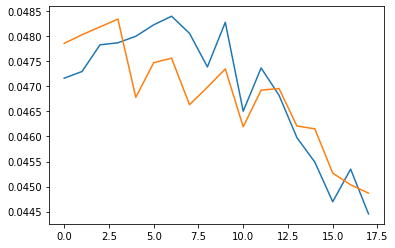

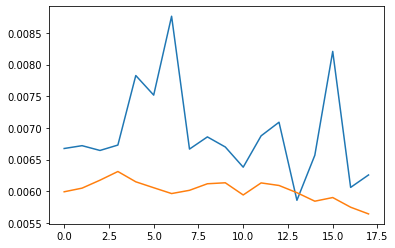

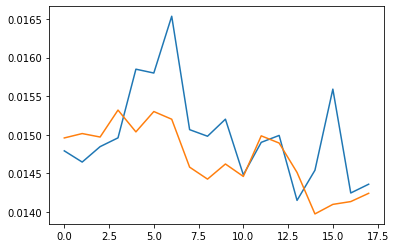

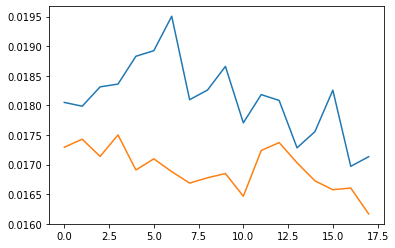

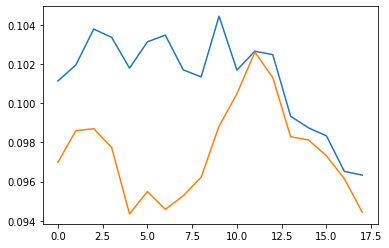

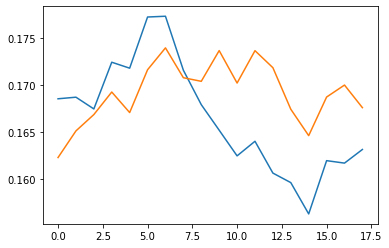

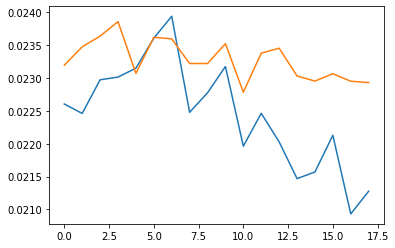

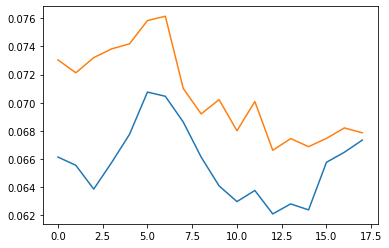

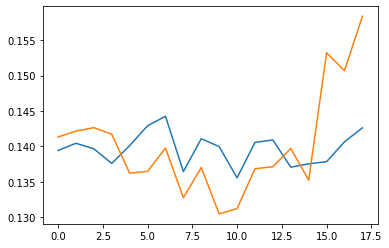

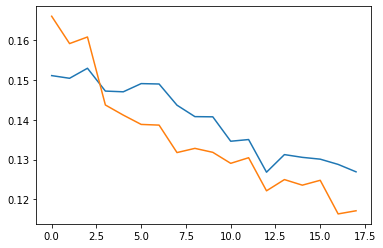

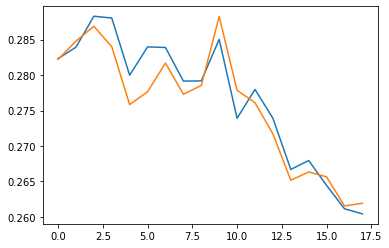

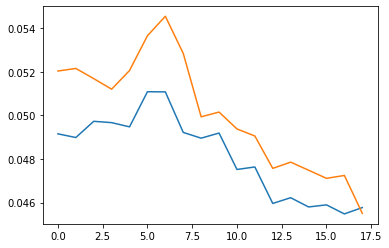

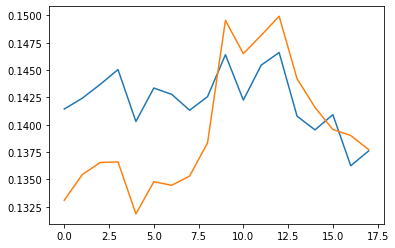

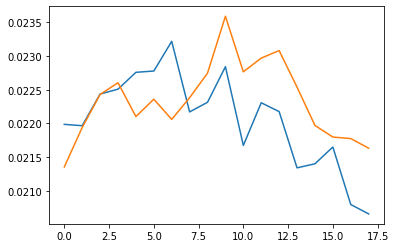

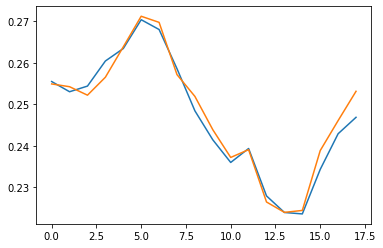

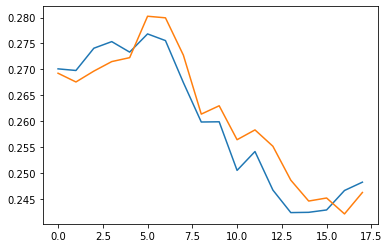

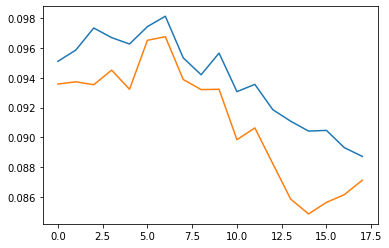

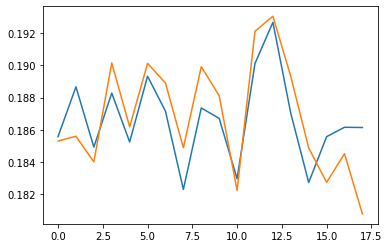

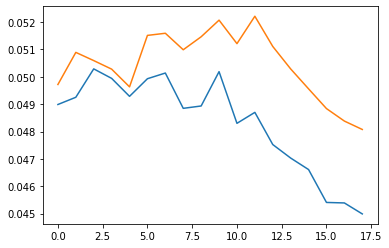

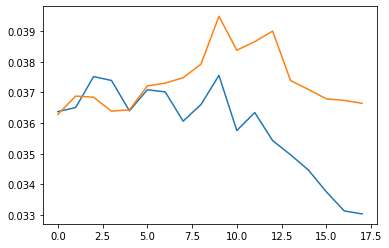

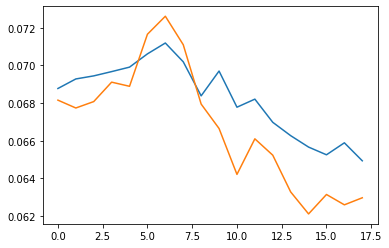

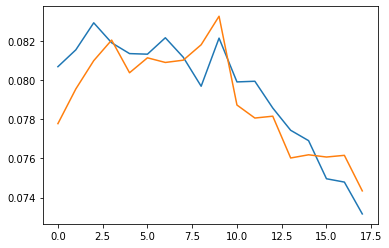

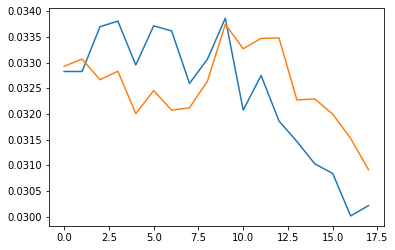

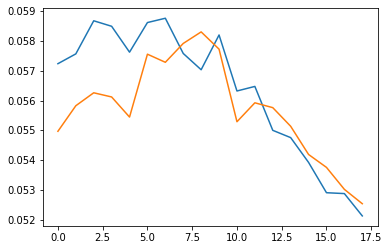

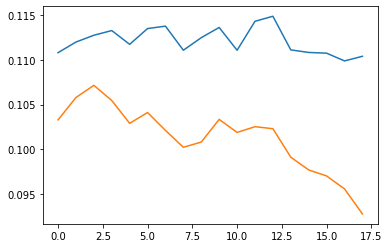

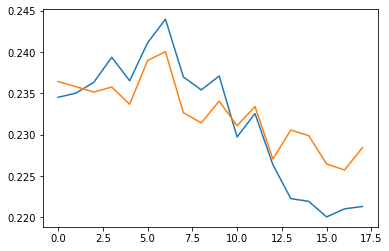

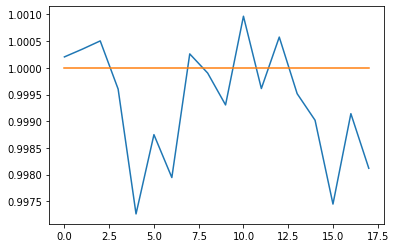

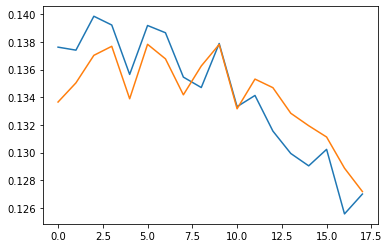

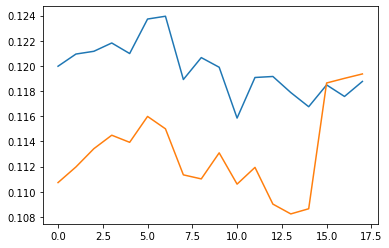

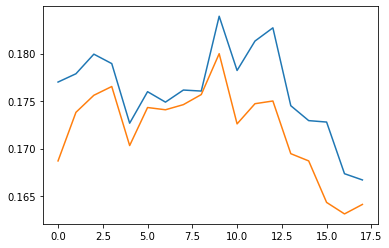

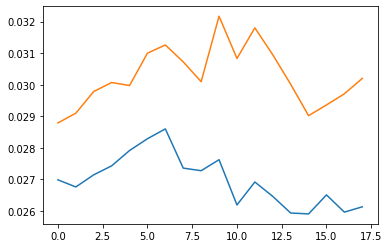

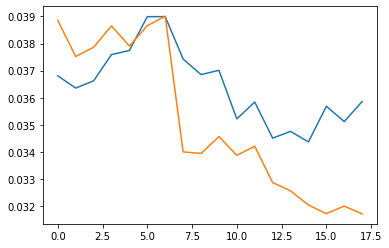

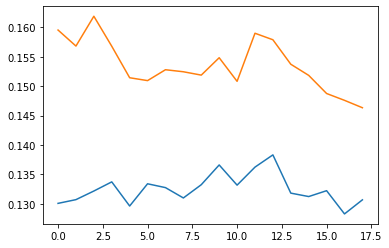

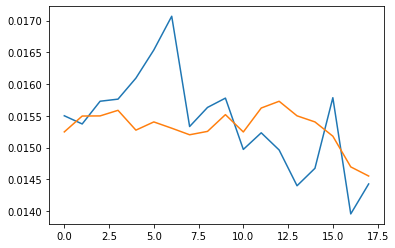

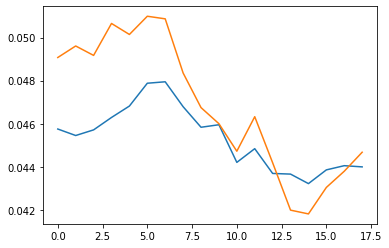

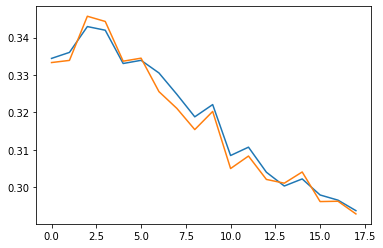

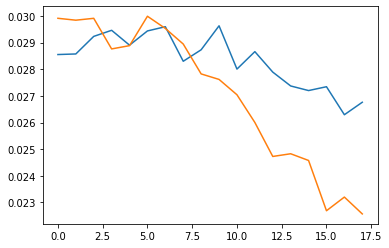

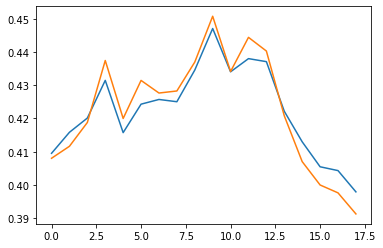

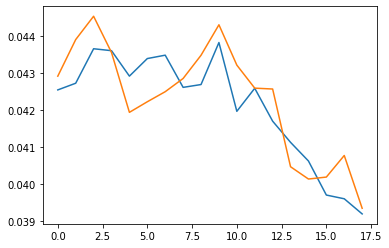

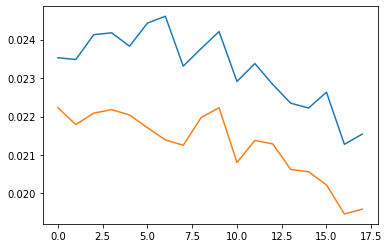

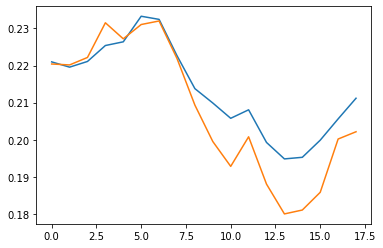

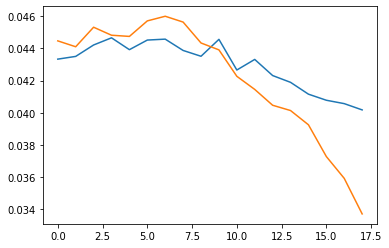

In [ ]:
for i in range(50):
  a = out[i][0].detach()
  b = y_train_final[i][0]
  plt.plot(a, label = "pred")
  plt.plot(b, label="true series")
  plt.show()

tensor(2.2802e-05)


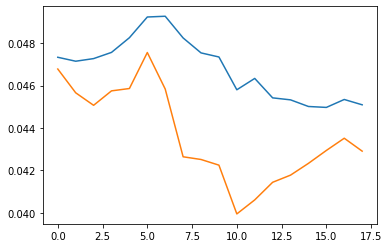

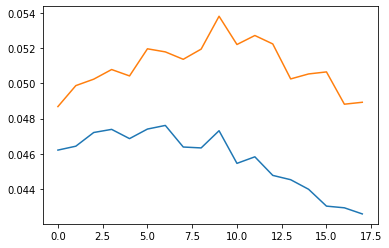

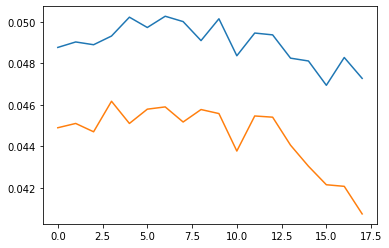

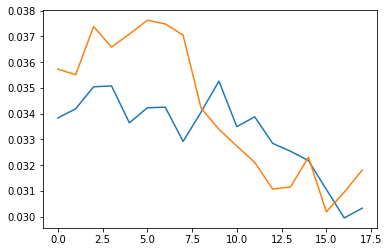

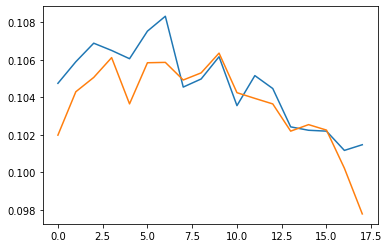

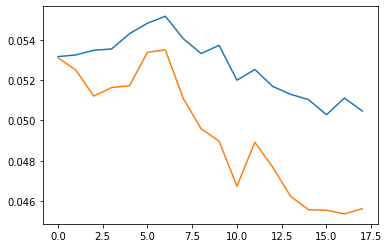

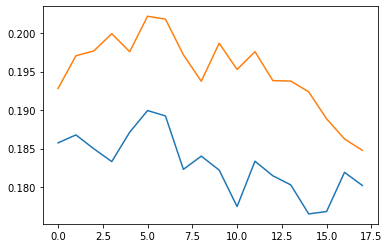

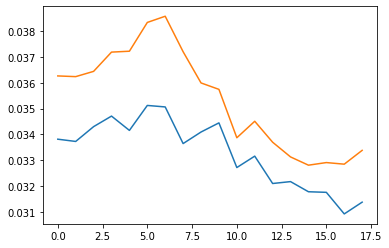

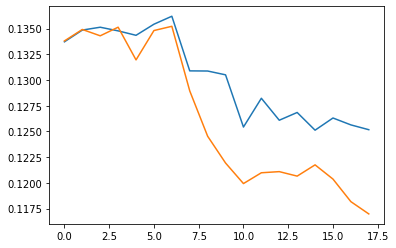

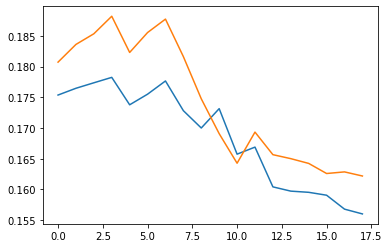

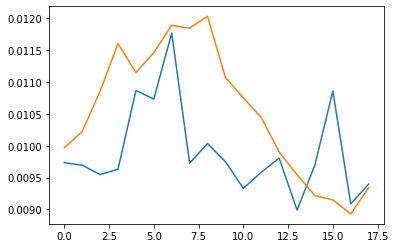

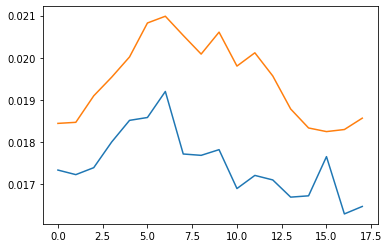

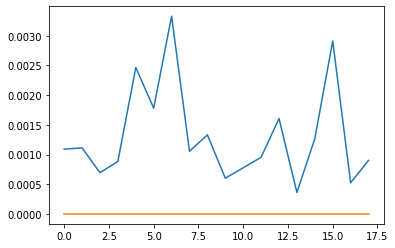

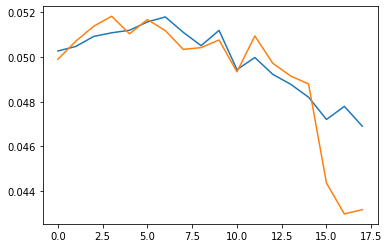

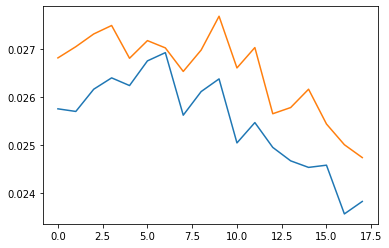

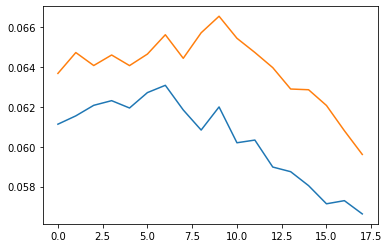

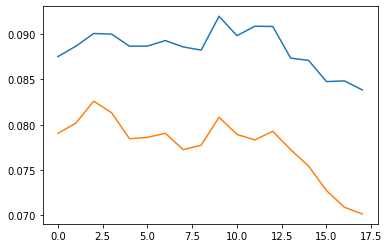

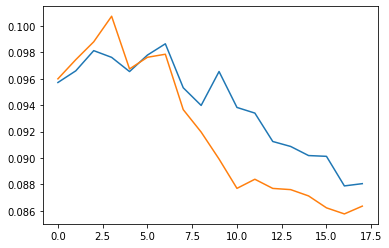

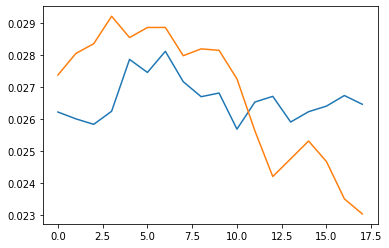

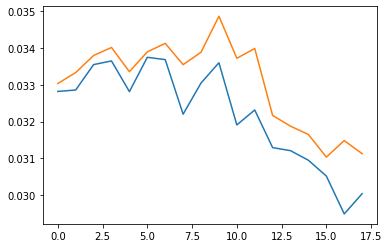

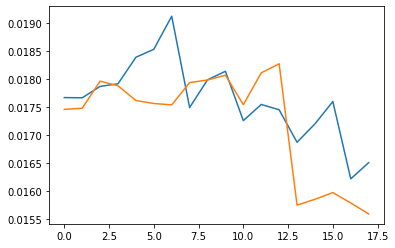

In [ ]:
# prediction: 
pred = my_lstm(X_test_final.float()).detach()
testloss = criterion(pred, y_test_final.float())
print(testloss)
for i in range(21):
  a = pred[i][0]
  b = y_test_final[i][0]
  plt.plot(a, label = "pred")
  plt.plot(b, label="true series")
  plt.show()

In [ ]:
# try on returns : returns would probably be better as there is some autoregressive elements to them. 
# try a lstm module with 3 cells and a kind of decoder; see if that works